In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Gradient Descent

As stated previouslu supervised learning is usually performed by minimizing a loss function with respect to its parameters. Usually the number of those parameters is very big, on the order of millions for modern neural networks. Most efficient minimization algorithms use some form gradient descent.  

Gradient of a scalar function of $N$ parameters $\textbf{w}=\left(w_0,\ldots,w_{N-1}\right)$ is a vector of all partial variables with respect to $w_i$: 

$$\newcommand{\grad}{\operatorname{grad}}$$

$$\grad_\textbf{w} L(\mathbf{w}) \equiv
\left(\frac{\partial L(\mathbf{w})}{\partial w_0},\ldots, \frac{\partial L(\mathbf{w})}{\partial w_{N-1}}\right)
$$

Gradient has the property that it points in the local direction in which the functions increases most rapidly (steepest ascent), so in the oposite direction function decreases most rapidly (steepest descent).   

Based on this the idea of the stepest descent algorithm is  to make steps in the direction  oposite to the gradient:

```
w = w_start
while(not minimised):
    g = grad(L,w)
    w = w - eta*g
```    


If this looks to good to be true, it is :(

First of all this algorithm can only takes us to a local minimum. But even this is not guarantied. The gradient contains only *local* information if the function changes rapidly we take to big steps we may overshoot the minimum and the proccess may be even divergent. On the other hand if the functions does not change rapidly the gradient becomes small, and so our steps and the algorith can take very long to converge. Thus  the parameter eta the so called *learning rate* plays in this proccess a crucial role. 

Later we will use more sophisticated algorithms that adjust the learning rate automaticaly, but for the moment we will stick with this "plain vanilla" gradient descent. 

## 1D example

We will start with a simple  quadratic function of one parameter:

In [10]:
def f(x, a = 1):
    return 0.5*a*x*x

def grad_f(x, a=1):
    return a*x

Below we visualize the function and its gradient in several points. Please not that gradient of one paremeter function is a scalar. The arrow in the figure represent the magnitude and the sign of the gradient. 

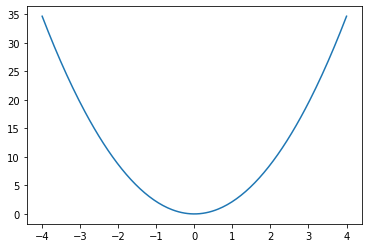

In [11]:
xs = np.linspace(-4,4,200)
a=13/3.0
ys = f(xs,a)
plt.plot(xs,ys);

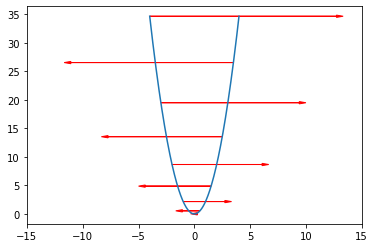

In [12]:
xs = np.linspace(-4,4,200)
a=13/3.0
ys = f(xs,a)
plt.plot(xs,ys)
plt.xlim(-15,15)
for x in [-4,-3,-2,-1, 0.5, 0.1,  1.5, 2.5, 3.5]:
    plt.arrow(x, f(x,a),-grad_f(x,a),0, color='red', width=0.01, head_width=0.4, length_includes_head=True)

As you can see the arrow point in the right direction (minimu) but we have to tune the learning rate as not overshoot from one slope to another.

Below is a simple implementation and visualisation of steepest descent. Please play with the learning rate. How many different "regimes" can you detect? Which learning rate would get you to minimum in a fastest way?

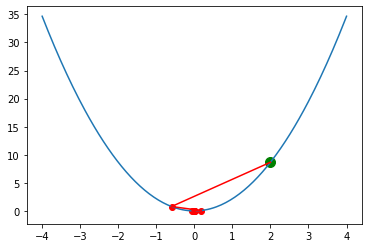

In [13]:
x  = 2
plt.scatter([x], [f(x,a)],facecolor='green', s=100)
eta = 0.3
ys = f(xs,a)
plt.plot(xs,ys)
for i in  range(7):
    x_next= x - eta*grad_f(x,a)
    plt.plot([x, x_next], [f(x,a),f(x_next,a)],c='red')
    x= x_next
    plt.scatter([x], [f(x,a)],c='red')
  

## 2D example

Lets move to a more interesting 2D example. 

We start by loading some data:

In [14]:
import os
dir_path = os.getcwd()
data = np.load(dir_path + "\\sgd_data.npy")
rxs = data[:50,0]
rys = data[:50,1]

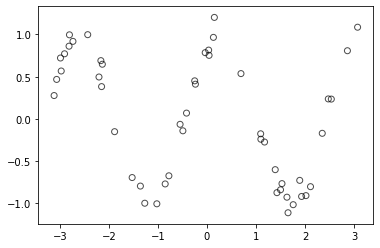

In [15]:
plt.scatter(rxs,rys, alpha=0.7, color='none', edgecolor="black");

We have "learn" the function represented by this data. We  restrict our search to functions of the form:

$$f(x|\omega, t) = \sin(\omega x +t)$$

Here $x$ is the input argument and $\omega$ and $t$ are parameters that define the function.

The python definition would be:

In [16]:
def fitf(x,o,t):
    return np.sin(x*o+t)

$$MSE(\omega,t|\textbf{x},\textbf{y}) = \frac{1}{2}\frac{1}{N}\sum_{i=1}^N \left(y_i-f(x_i|\omega, t)\right)^2 $$

In [17]:
def mse(f, x, y, o, t):
        err = f(x,o,t)-y
        return 0.5*np.sum(err*err, axis=-1)/len(x)

In the return statement the sum is taken over the last dimension of the tensor. When this tensor is an array as was the case so far this is just a normal sum. The neccesity of this form will be clear in a moment when we will visualize the error functions.  

The loss function is a scalar function of two parameters. We will visualize it using `countourf` function from matplotlib.  This function takes three parameters,  each a two dimensional array with same dimensions. 


```python
contourf(x,y,z)
```

Arrays x and y define a regular grid of points. x contains the x coordinates and y corresponding y coordinates. Array z contains the value of function (z coordinate) at this point.  

$$z_{ij}= f(x_{ij}, y_{ij})$$

<div>
    The arrays x and y can automatically generated using function <code>meshgrid</code> from numpy:
    </div>

In [18]:
grid_size = 500
os = np.linspace(0, 2*np.pi, grid_size)
ts = np.linspace(-np.pi,np.pi,grid_size)
otg = np.meshgrid(os,ts)

otg[0] now contains the  grid values of $\omega$ parameter and otg[1] grid values of $t$ parameter. 

To calculate the z values we need to evaluate the `fitf` for every pair of $\omega$ and $t$ in otg:

In [19]:
%%time
vg = np.empty((grid_size,grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        vg[i,j]=mse(fitf, rxs,rys, otg[0][i,j], otg[1][i,j])

Wall time: 3.94 s


While this approach works it's not a good idea in general as explained in tensorsComputations notebook. Instead of using explicit loops we should use implicit looping provided by numpy. Below is a version of `fitf` function that takes tensor arguments for $\omega$ nad $t$ and loops simulatneously over both of them.  Those tensor must have same shapes.

In [20]:
def fitf_tensor(x,o,t):
    return np.moveaxis(np.sin(np.tensordot(np.atleast_1d(x),o,0)+t),0,-1)

Let's pry this function appart. 

For simplicity let's assume that $x$ is one dimensional tensor and $\omega$ and $t$ are two dimensional. 

Function `tensordot` whit last argument zero is an outer product so the result is a three dimensional tensor

$$x_i o_{jk}$$

Then we add to it a two dimensional tensor $t$ which is broadcast to three dimensions and the result is:

$$x_i o_{jk}+t_{jk}$$

Then applying `sin` function calculates sine of all the elements and returns them as three dimensional array of the same shape.

Finally as we want the $i$ dimension to be the last so we transpose it using `moveaxis`.

In [21]:
%%time
vg = mse(fitf_tensor, rxs, rys, otg[0], otg[1])

Wall time: 736 ms


As you can see this is much faster :)

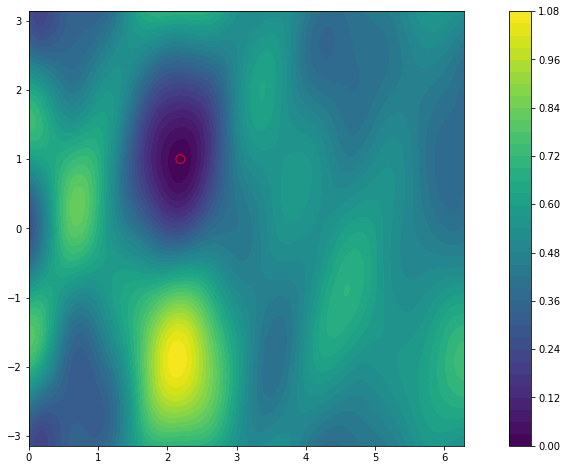

In [22]:
from matplotlib import gridspec

fig = plt.figure(figsize=(9,8))
gs=gridspec.GridSpec(1,2, width_ratios=[4,0.2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
cs=ax1.contourf(otg[0], otg[1],vg, levels=40);
fig.colorbar(cs, cax=ax2);
ax1.scatter([2.188], [1],c='none', s=80, edgecolor='red');

This plot explains why we have used the $\sin$ function in our example. We wanted a function that even with only two parameters gives a non trivial loss function "landscape". 

## Gradient Descent

To implement the gradient descent we have to calculate the gradient of this function
For this simple function we can do it analiticaly. First for parameter $\omega$:


$$f(x|\omega, t) = \sin(\omega x +t)$$
$$\frac{\partial }{\partial \omega}MSE(\omega,t) = -\frac{1}{N}\sum_{i=1}^N  \left(y_i-f(x_i|\omega, t)\right)\cos(\omega x +t) x$$

and for parameter $t$:

$$\frac{\partial }{\partial t}MSE(\omega,t) = \frac{1}{N}\sum_{i=1}^N  \left(y_i-f(x_i|\omega, t)\right)\cos(\omega x +t) $$

And this is the equivalent Python function:

In [23]:
def grad(x,y, o, t):
    residue = y-np.sin(o*x+t)
    return np.array((
        -np.sum(residue*np.cos(o*x+t)*x),
        -np.sum(residue*np.cos(o*x+t))
         
    ))/len(x)

Below is the implementation and visualization of the stepest descent algorithm. Please play with parameters: starting point, learning rate and number of iterations. 

In [24]:
fig, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].contourf(otg[0], otg[1],vg, levels=20)
p =[3, 1]
ax[0].scatter([p[0]], [p[1]],c='none', s=20, edgecolor='red')
eta = 0.1
trajectory_list=[]
n_iter = 50
for i in range(n_iter):
    g = grad(rxs, rys, p[0], p[1])
    p -= eta*g
    trajectory_list.append(np.concatenate((g,p,[mse(fitf,rxs, rys,*p)])))
    ax[0].scatter([p[0]], [p[1]],c='red', s=20, edgecolor='red')
print(p, -g)
trajectory=np.stack(trajectory_list)
ax[1].plot(np.arange(n_iter),trajectory[:,-1],'.')
ax[1].set_xlabel("n iterations")
ax[1].set_ylabel("MSE", color="blue")

tw = ax[1].twinx()
tw.spines['right'].set_color('red')
tw.tick_params(axis='y', colors='red')
tw.set_ylabel("||grad||", color="red")

tw.plot(np.arange(n_iter),np.linalg.norm(trajectory[:,:2], axis=1),'.r')

# The commands below ensure that the zero of lefvt and right vertical axes are on the same level. 
# If error does not go to zero this may cause gradinet not to be displayed
l1,u1 = ax[1].get_ylim()
l2,u2 = tw.get_ylim();
nl2=(u2-l2)/(u1-l1)*l1
dl2=nl2-l2
tw.set_ylim(l2+dl2,u2+dl2);
# This is just for notebook, so I can split it on two slides. You can remove this while playing with this
plt.close() 

[2.18765323 0.97455343] [-0.00077353 -0.00606866]


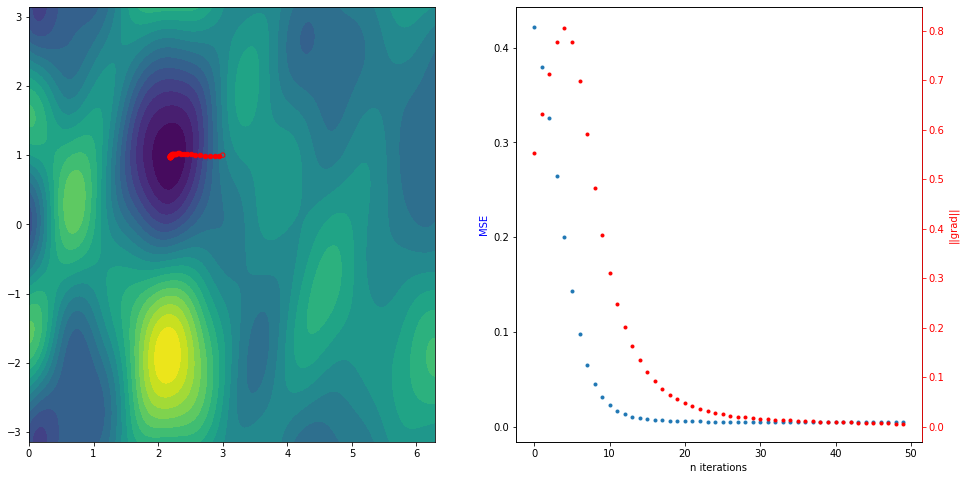

In [25]:
fig

Figure on the left show the trajectory superimposed on the MSE plot. On the right we show the MSE error and length of the gradient as a function of the number of iterations.

### Stoping criterion

## Blind date

Now imagine you are doing it blindly :) 

Please find  good parameters using this "hidden" data without looking at the landscape plot. That should give you some idea how difficult this may be in case of neural network where we cannot visualize the loss function. 

In [26]:
data_hidden = np.load("sgd_data_hidden.npy")
rxs_hidden = data_hidden[:,0]
rys_hidden = data_hidden[:,1]

In [27]:
fig, ax =  plt.subplots(1,2,figsize=(16,8))
ax[0].set_xlim(0, 2*np.pi)
ax[0].set_ylim(-np.pi, np.pi)

p =[2, 1]
ax[0].scatter([p[0]], [p[1]],c='none', s=20, edgecolor='red')
eta = 0.2
trajectory_list=[]
n_iter = 50
for i in range(n_iter):
    g = grad(rxs_hidden, rys_hidden, p[0], p[1])
    p -= eta*g
    trajectory_list.append(np.concatenate((g,p,[mse(fitf,rxs_hidden, rys_hidden,*p)])))
    ax[0].scatter([p[0]], [p[1]],c='red', s=20, edgecolor='red')
print(p, -g)
trajectory=np.stack(trajectory_list)
ax[1].plot(np.arange(n_iter),trajectory[:,-1],'.')
ax[1].set_xlabel("n iterations")
tw = ax[1].twinx()
tw.plot(np.arange(n_iter),np.linalg.norm(trajectory[:,:2], axis=1),'.r')

ax[1].set_ylabel("MSE", color="blue")

tw.spines['right'].set_color('red')
tw.tick_params(axis='y', colors='red')
tw.set_ylabel("||grad||", color="red");
plt.close()

[2.26245845 0.32864288] [ 0.00704921 -0.04299916]


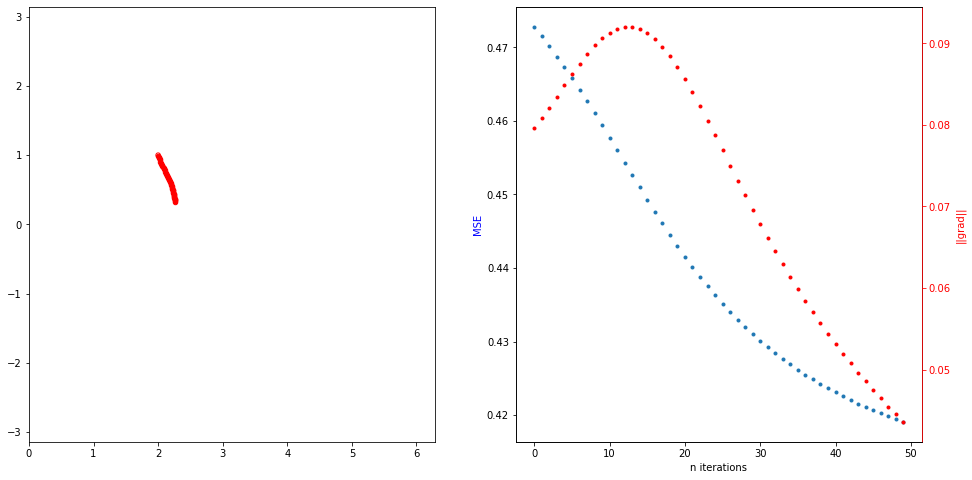

In [28]:
fig